<a href="https://colab.research.google.com/github/harisonmg/tensorflow-exam-prep/blob/main/learning_rate_scheduling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generating the data

In [1]:
#@title Imports
import numpy as np

In [2]:
#@title Helper functions
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [3]:
#@title Config
baseline = 10 #@param {type:"slider", min:1, max:25, step:1}
slope = 0.1 #@param {type:"slider", min:0.02, max:0.2, step:0.01}
amplitude = 40 #@param {type:"slider", min:10, max:100, step:10}
period = 365 #@param {type:"slider", min:50, max:500, step:5}
noise_level = 5 #@param {type:"slider", min:1, max:10, step:1}

In [4]:
#@title Generating the time series data
time = np.arange(4 * period + 1, dtype="float32")
series = baseline + trend(time, slope) + seasonality(time, amplitude=amplitude, period=period)
series += noise(time, noise_level, seed=42)

In [5]:
#@title Creating training and validation splits
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Visualizing the data

In [6]:
#@title Imports
import matplotlib.pyplot as plt

In [7]:
#@title Helper function
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

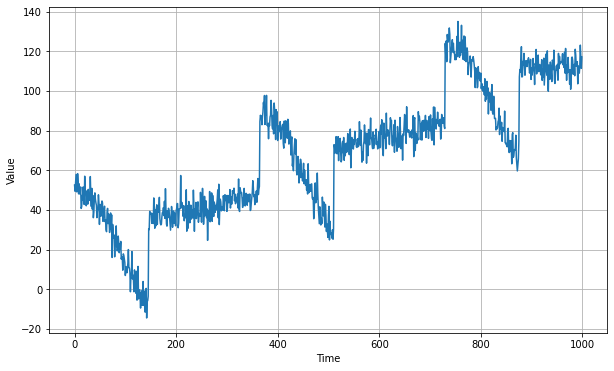

In [8]:
#@title Visualizing the training data 
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)

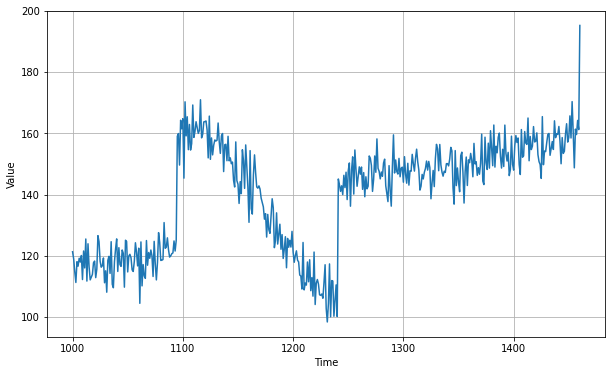

In [9]:
#@title Visualizing the validation data 
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

## Creating a TensorFlow Dataset

In [10]:
#@title Imports
from tensorflow.data import Dataset

In [11]:
#@title Helper function
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [12]:
#@title Config
window_size = 20 #@param {type:"slider", min:10, max:50, step:10}
batch_size = 32 #@param {type:"slider", min:4, max:64, step:4}
shuffle_buffer_size = 1000 #@param {type:"slider", min:500, max:2500, step:100}

In [13]:
#@title Creating the windowed Dataset
dataset = windowed_dataset(
    x_train, window_size, batch_size, shuffle_buffer_size
)

## Training the model

In [14]:
#@title Imports
from tensorflow.keras import callbacks, layers, models, optimizers
import tensorflow as tf

print(f"TensorFlow: {tf.__version__}")

TensorFlow: 2.6.0


In [15]:
#@title Config
epochs = 100
learning_rate = 1e-6
momentum = 0.9
verbose = 0

In [16]:
#@title Model definition
model = models.Sequential([
    layers.Dense(10, input_shape=[window_size], activation="relu"), 
    layers.Dense(10, activation="relu"), 
    layers.Dense(1)
])

model.compile(
    loss="mse",
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentum
    )
)

In [17]:
#@title Training the model
history = model.fit(dataset, epochs=epochs, verbose=verbose)

## Model evaluation

In [18]:
#@title Imports
from tensorflow.keras import metrics

In [19]:
#@title Getting the predictions
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.squeeze(forecast)

MAE: 4.87807035446167


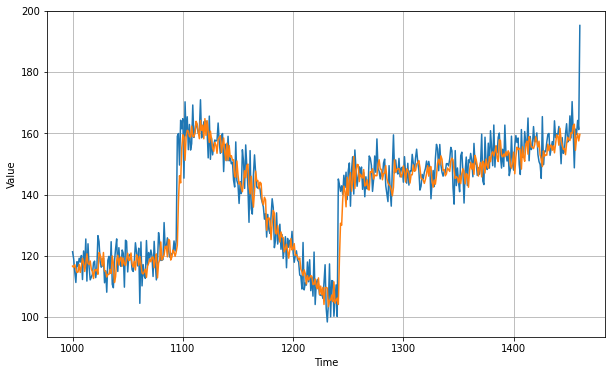

In [20]:
#@title Visualizing the predictions and metrics
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

print(f"MAE: {metrics.mean_absolute_error(x_valid, results)}")

## Finding the optimal learning rate

In [21]:
#@title Define the learning rate schedule
def change_learning_rate(epoch):
    return 1e-8 * 10**(epoch / 20)

In [22]:
#@title Callbacks
model_callbacks = [
    callbacks.LearningRateScheduler(change_learning_rate),
]

In [23]:
#@title Config
epochs = 100
learning_rate = 1e-6
momentum = 0.9
verbose = 0

In [24]:
#@title Model definition
model = models.Sequential([
    layers.Dense(10, input_shape=[window_size], activation="relu"), 
    layers.Dense(10, activation="relu"), 
    layers.Dense(1)
])

model.compile(
    loss="mse",
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentum
    )
)

In [25]:
#@title Training the model
history = model.fit(
    dataset,
    epochs=epochs,
    callbacks=model_callbacks,
    verbose=verbose
)

Optimal learning rate: 1.584893192461114e-05


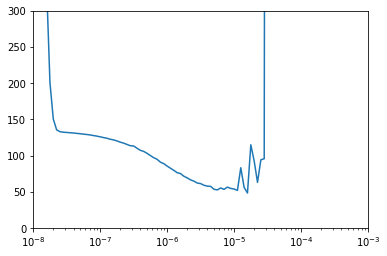

In [26]:
#@title Visualizing the learning rates vs loss
learning_rates = np.vectorize(change_learning_rate)(np.arange(100))
loss = np.array(history.history["loss"])
plt.semilogx(learning_rates, loss)
plt.axis([1e-8, 1e-3, 0, 300])

optimal_learning_rate = learning_rates[np.argmin(loss)]
print(f"Optimal learning rate: {optimal_learning_rate}")

## Training the model with the optimal learning rate

In [27]:
#@title Config
epochs = 500
learning_rate = np.round(optimal_learning_rate, 6)
momentum = 0.9
verbose = 1

print(f"Learning rate: {learning_rate}")

Learning rate: 1.6e-05


In [28]:
#@title Model definition
model = models.Sequential([
    layers.Dense(10, input_shape=[window_size], activation="relu"), 
    layers.Dense(10, activation="relu"), 
    layers.Dense(1)
])

model.compile(
    loss="mse",
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentum
    )
)

In [29]:
#@title Training the model
history = model.fit(dataset, epochs=epochs, verbose=verbose)

Epoch 1/500
31/31 [==============================] - 1s 3ms/step - loss: 922.6619
Epoch 2/500
31/31 [==============================] - 0s 2ms/step - loss: 83.8373
Epoch 3/500
31/31 [==============================] - 0s 3ms/step - loss: 69.7080
Epoch 4/500
31/31 [==============================] - 0s 2ms/step - loss: 136.2004
Epoch 5/500
31/31 [==============================] - 0s 3ms/step - loss: 80.8513
Epoch 6/500
31/31 [==============================] - 0s 2ms/step - loss: 63.8134
Epoch 7/500
31/31 [==============================] - 0s 3ms/step - loss: 82.8350
Epoch 8/500
31/31 [==============================] - 0s 3ms/step - loss: 53.6089
Epoch 9/500
31/31 [==============================] - 0s 3ms/step - loss: 56.9474
Epoch 10/500
31/31 [==============================] - 0s 2ms/step - loss: 69.0013
Epoch 11/500
31/31 [==============================] - 0s 2ms/step - loss: 79.1494
Epoch 12/500
31/31 [==============================] - 0s 2ms/step - loss: 53.7339
Epoch 13/500
31/31 [===

## Model evaluation

In [30]:
#@title Imports
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# sns.set_theme(style="whitegrid")

In [31]:
#@title Helper function
def get_metrics(training_history, metric, validation=True):
    metrics = {
        metric: training_history.get(metric)
    }
    if validation:
        val_metric = "val_" + metric
        metrics[val_metric] = training_history.get(val_metric)
    return pd.DataFrame(metrics)

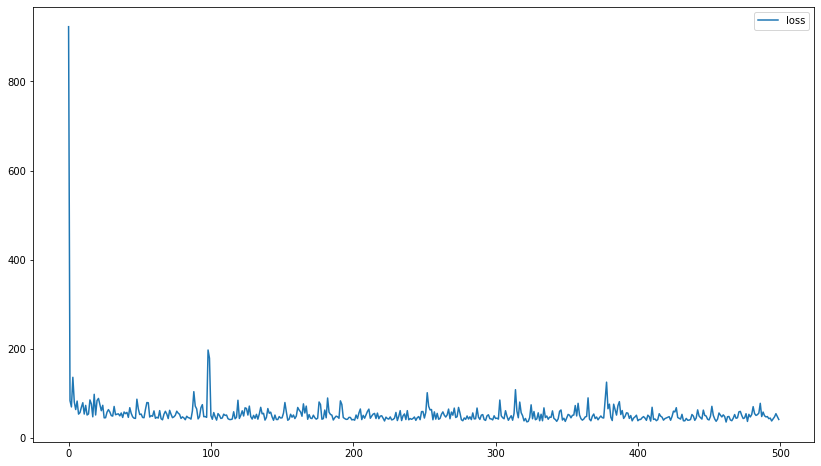

In [32]:
#@title Plot training metrics
fig, ax = plt.subplots(figsize=(14, 8))

loss = get_metrics(history.history, "loss", validation=False)
sns.lineplot(data=loss, ax=ax)
plt.show()

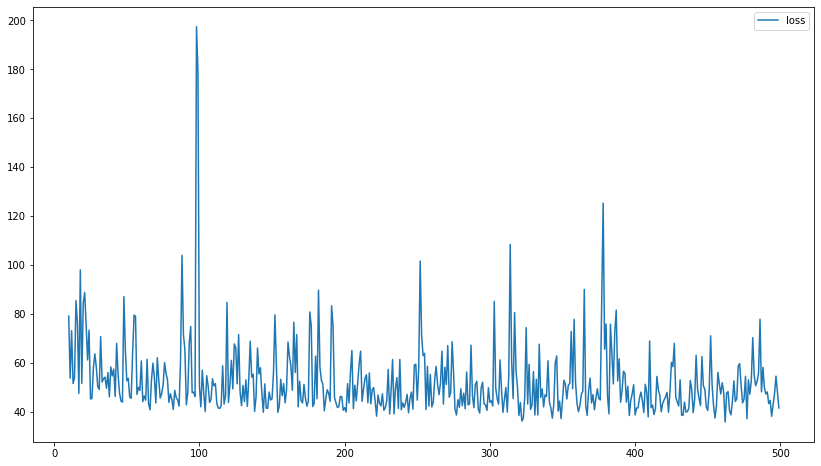

In [33]:
#@title Zooming in
fig, ax = plt.subplots(figsize=(14, 8))

sns.lineplot(data=loss.loc[10:], ax=ax)
plt.show()

In [34]:
#@title Getting the predictions
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.squeeze(forecast)

MAE: 6.463104248046875


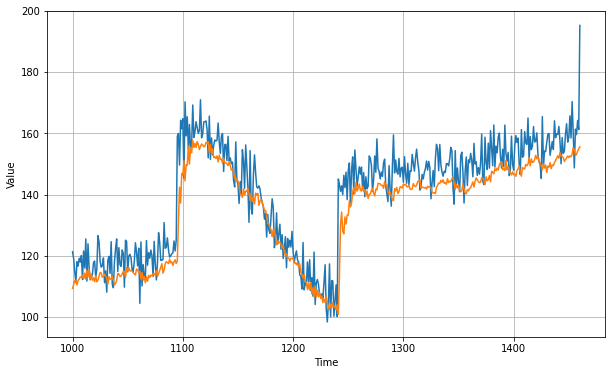

In [35]:
#@title Visualizing the predictions and metrics
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

print(f"MAE: {metrics.mean_absolute_error(x_valid, results)}")